In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import random
import numpy as np
from seirsplus.networks import generate_demographic_contact_network, household_country_data
from seirsplus.viral_model import ViralExtSEIRNetworkModel
from seirsplus.sim_loops_pooled_test import SimulationRunner

## Note: these are results of experiments started 7/13 night, submitted to G2. 

In [3]:
import os

os.listdir('/home/yz685/corr_pooling_seirsplus/results/')

['deprecated',
 'US_pop_size=10000_init_prev=0.001_num_groups=10_pool_size=10_horizon=100_beta=0.5_sigma=0.2_lamda=0.5_gamma=0.25_LoD=174',
 'US_pop_size=10000_init_prev=0.01_num_groups=10_pool_size=10_horizon=100_beta=0.5_sigma=0.2_lamda=0.5_gamma=0.25_LoD=174',
 'US_pop_size=10000_init_prev=0.01_num_groups=10_pool_size=5_horizon=100_beta=0.5_sigma=0.2_lamda=0.5_gamma=0.25_LoD=174',
 'US_pop_size=10000_init_prev=0.1_num_groups=10_pool_size=20_horizon=100_beta=0.5_sigma=0.2_lamda=0.5_gamma=0.25_LoD=174',
 'US_pop_size=10000_init_prev=0.001_num_groups=10_pool_size=30_horizon=100_beta=0.5_sigma=0.2_lamda=0.5_gamma=0.25_LoD=174',
 'US_pop_size=10000_init_prev=0.1_num_groups=10_pool_size=5_horizon=100_beta=0.5_sigma=0.2_lamda=0.5_gamma=0.25_LoD=174',
 'US_pop_size=10000_init_prev=0.001_num_groups=10_pool_size=5_horizon=100_beta=0.5_sigma=0.2_lamda=0.5_gamma=0.25_LoD=174',
 'US_pop_size=10000_init_prev=0.1_num_groups=10_pool_size=30_horizon=100_beta=0.5_sigma=0.2_lamda=0.5_gamma=0.25_LoD=17

In [19]:
import pickle

NUM_TRIALS = 50


param_config = {
    "country": ["US"],

    "pop_size_default": 10000,

    "init_prev": [0.001, 0.01, 0.1],
    "init_prev_default": 0.01,

    'horizon_default': 100,

    "num_groups_default": 5,
    # "num_groups": [1, 5],
    "num_groups": [5],

    'pool_size': [10],
    'pool_size_default': 10,

    'LoD_default': 1240,
    'LoD': [1240],

    "edge_weight_default": 10,
    "edge_weight": [10],

    "alpha_default": 5.0,
    # "alpha": [1.0, 2.0, 5.0],
    "alpha": [2.0, 5.0],

    "peak_VL": [6.0, 6.5, 7.0],

    "beta_default": 0.1, # transmissibility
    "sigma_default": 0.2, # rate E --> I_pre
    "lamda_default": 0.5, # rate I_pre --> I_(a)sym
    "gamma_default": 0.25 # rate I_sym --> R
}


In [20]:
import itertools

param_values = {}

for param in [
        "country", "pop_size", "init_prev", "num_groups", "pool_size", "horizon", 
        "beta", "sigma", "lamda", "gamma", "LoD", "edge_weight", "alpha", "peak_VL"
    ]:
        if param in param_config:
            param_values[param] = param_config[param]
        else:
            param_values[param] = [param_config[param+"_default"]]

all_param_configs = [dict(zip(param_values.keys(), x)) for x in itertools.product(*param_values.values())]

In [5]:
all_param_configs

[{'country': 'US',
  'pop_size': 10000,
  'init_prev': 0.001,
  'num_groups': 5,
  'pool_size': 10,
  'horizon': 100,
  'beta': 0.1,
  'sigma': 0.2,
  'lamda': 0.5,
  'gamma': 0.25,
  'LoD': 1240,
  'edge_weight': 10,
  'alpha': 5.0,
  'peak_VL': 6.0},
 {'country': 'US',
  'pop_size': 10000,
  'init_prev': 0.001,
  'num_groups': 5,
  'pool_size': 10,
  'horizon': 100,
  'beta': 0.1,
  'sigma': 0.2,
  'lamda': 0.5,
  'gamma': 0.25,
  'LoD': 1240,
  'edge_weight': 10,
  'alpha': 5.0,
  'peak_VL': 6.5},
 {'country': 'US',
  'pop_size': 10000,
  'init_prev': 0.001,
  'num_groups': 5,
  'pool_size': 10,
  'horizon': 100,
  'beta': 0.1,
  'sigma': 0.2,
  'lamda': 0.5,
  'gamma': 0.25,
  'LoD': 1240,
  'edge_weight': 10,
  'alpha': 5.0,
  'peak_VL': 7.0},
 {'country': 'US',
  'pop_size': 10000,
  'init_prev': 0.01,
  'num_groups': 5,
  'pool_size': 10,
  'horizon': 100,
  'beta': 0.1,
  'sigma': 0.2,
  'lamda': 0.5,
  'gamma': 0.25,
  'LoD': 1240,
  'edge_weight': 10,
  'alpha': 5.0,
  'peak_

In [21]:
df_data = []

In [22]:
import copy
from collections import defaultdict
def defaultdict_list():
    return defaultdict(list)

# paths = []

all_data = []
trajectories = [] # list of tuples (dict of param_config_single, dict of {metric: [mean, std]})

for param_config_single in all_param_configs:

    traj_info = [param_config_single, {}]
    
    path = f"/home/yz685/corr_pooling_seirsplus/results/{param_config_single['country']}"
    for param in [
        "pop_size", "init_prev", "num_groups", "pool_size", "horizon", 
        "beta", "sigma", "lamda", "gamma", "LoD", "edge_weight", "alpha", "peak_VL"
    ]:
        path += f"_{param}={param_config_single[param]}"

    data = copy.deepcopy(param_config_single)

    # paths.append(path)

    results = defaultdict(list)

    for pooling_strategy in ["naive", "correlated"]:
        for i in range(1, NUM_TRIALS+1):
            filepath = path + f"/{pooling_strategy}/results_{i}.pickle"
            try:
                with open(filepath, "rb") as f:
                    results[pooling_strategy].append(pickle.load(f))
            except Exception as e:
                # print("error: ", e)
                continue

    if len(results["naive"]) == 0:
        continue

    # metrics = set(results["correlated"][0][0].keys()) - set(["day"])

    # for metric in metrics:
    for metric in ["cumInfections", "cum_num_tests", "daily_sensitivity", "numActiveInfections", "mean_num_positives_in_positive_pool"]:
        naive_results = []
        correlated_results = []
        for SEED in range(NUM_TRIALS):
            try:
                naive_results.append(
                    [x[metric]\
                    for x in results["naive"][SEED]]
                )
            except:
                pass
            try:
                correlated_results.append(
                    [x[metric]\
                    for x in results["correlated"][SEED]]
                )
            except:
                pass

        naive_results_ = np.array([(xi+[None]*(100-len(xi)))[:100] for xi in naive_results], dtype=float)
        correlated_results_ = np.array([(xi+[None]*(100-len(xi)))[:100] for xi in correlated_results][:100], dtype=float)
        naive_mean = np.nanmean(naive_results_, axis=0)
        naive_sem = np.nanstd(naive_results_, axis=0)/np.sqrt(NUM_TRIALS)
        correlated_mean = np.nanmean(correlated_results_, axis=0)
        correlated_sem = np.nanstd(correlated_results_, axis=0)/np.sqrt(NUM_TRIALS)

        traj_info[1][metric] = [naive_mean, naive_sem, correlated_mean, correlated_sem]

        # print("naive_mean: ", naive_mean)

        # cumulative metrics
        if metric in ["cumInfections", "cum_num_tests"]:
            data[f"{metric}_NP_mean"] = naive_mean[-1]
            data[f"{metric}_CP_mean"] = correlated_mean[-1]
            data[f"{metric}_NP_sem"] = naive_sem[-1]
            data[f"{metric}_CP_sem"] = correlated_sem[-1]
        else:
            data[f"{metric}_NP_mean"] = np.nanmean(naive_mean)
            data[f"{metric}_CP_mean"] = np.nanmean(correlated_mean)
            # data[f"{metric}_NP_sd"] = naive_std[-1]
            # data[f"{metric}_CP_sd"] = correlated_std[-1]
        
    
    all_data.append(data)
    trajectories.append(traj_info)


In [24]:
for i, j in enumerate(traj_info[1].keys()):
    print(i,j)

0 cumInfections
1 cum_num_tests
2 daily_sensitivity
3 numActiveInfections
4 mean_num_positives_in_positive_pool


In [23]:
# [naive_mean, naive_sem, correlated_mean, correlated_sem]

def plot_trajectory(traj_info):

    print(f"init_prev={traj_info[0]['init_prev']}, peak_VL={traj_info[0]['peak_VL']}, num_groups={traj_info[0]['num_groups']}, alpha={traj_info[0]['alpha']}, pool_size={traj_info[0]['pool_size']}, LoD={traj_info[0]['LoD']}, edge_weight={traj_info[0]['edge_weight']}")

    fig, axs = plt.subplots(1, len(traj_info[1].keys()), figsize=(5*len(traj_info[1].keys()), 3))

    for i, metric in enumerate(traj_info[1].keys()):
        
        naive_mean = traj_info[1][metric][0]
        naive_std = traj_info[1][metric][1]
        correlated_mean = traj_info[1][metric][2]
        correlated_std = traj_info[1][metric][3]

        axs[i].plot(naive_mean, color="mediumpurple", label="naive")
        axs[i].fill_between(
            range(len(naive_mean)),
            naive_mean-2*naive_std,
            naive_mean+2*naive_std,
            alpha=0.2,
            color="mediumpurple"
        )
        axs[i].plot(correlated_mean, color="mediumseagreen", label="correlated")
        axs[i].fill_between(
            range(len(correlated_mean)),
            correlated_mean-2*correlated_std,
            correlated_mean+2*correlated_std,
            alpha=0.2,
            color="mediumseagreen"
        )
        axs[i].set_title(f"{metric} ")
        axs[i].legend()
    plt.show()

init_prev=0.001, peak_VL=6.0, num_groups=5, alpha=2.0, pool_size=10, LoD=1240, edge_weight=10


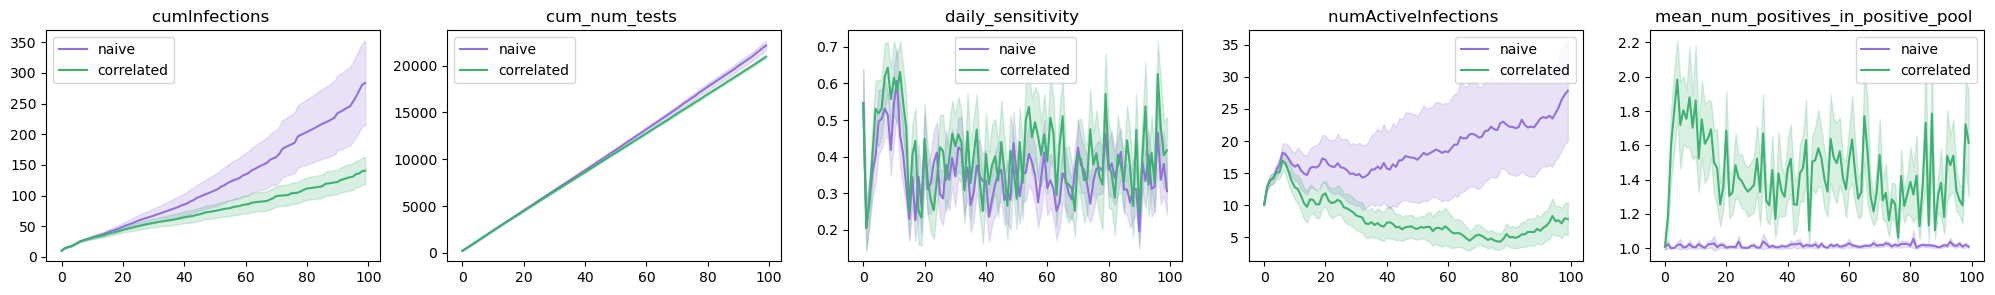

init_prev=0.001, peak_VL=6.5, num_groups=5, alpha=2.0, pool_size=10, LoD=1240, edge_weight=10


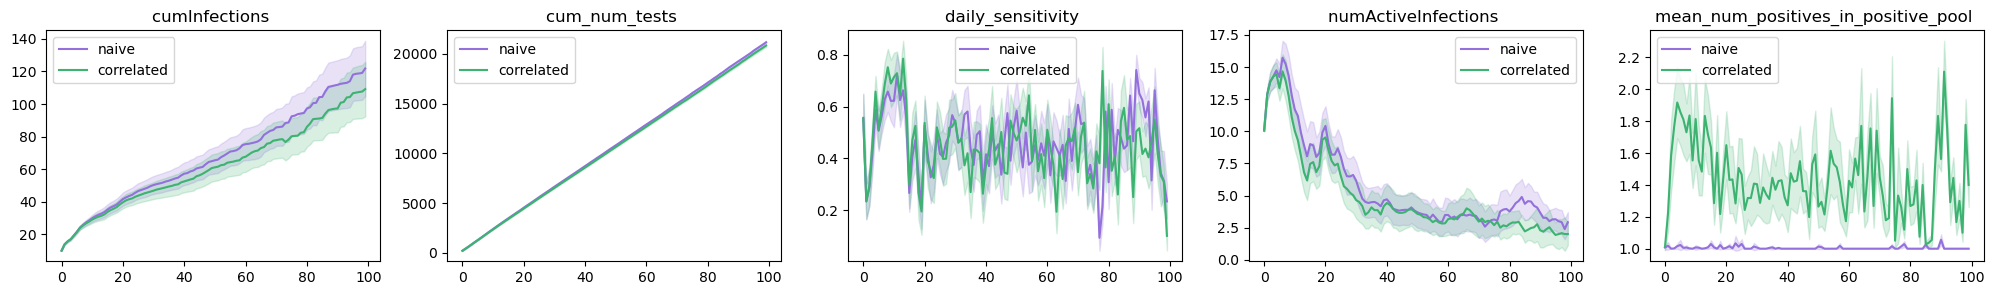

init_prev=0.001, peak_VL=7.0, num_groups=5, alpha=2.0, pool_size=10, LoD=1240, edge_weight=10


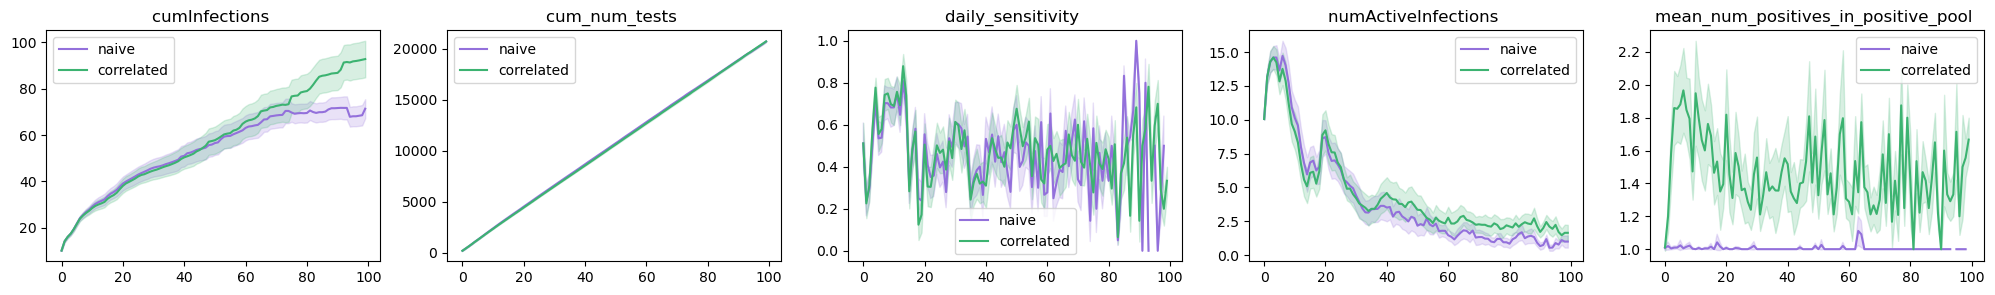

init_prev=0.001, peak_VL=6.0, num_groups=5, alpha=5.0, pool_size=10, LoD=1240, edge_weight=10


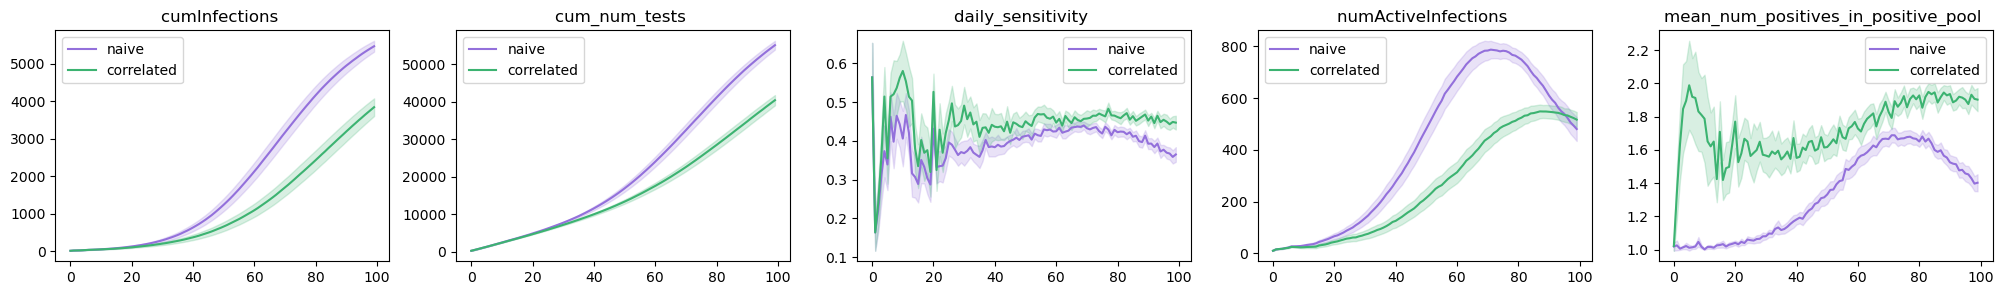

init_prev=0.001, peak_VL=6.5, num_groups=5, alpha=5.0, pool_size=10, LoD=1240, edge_weight=10


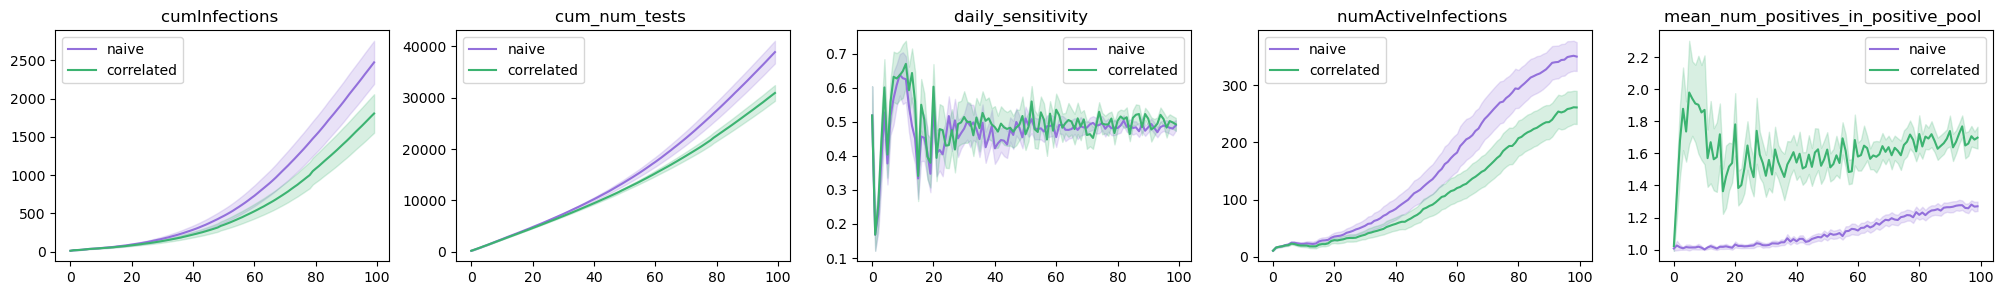

init_prev=0.001, peak_VL=7.0, num_groups=5, alpha=5.0, pool_size=10, LoD=1240, edge_weight=10


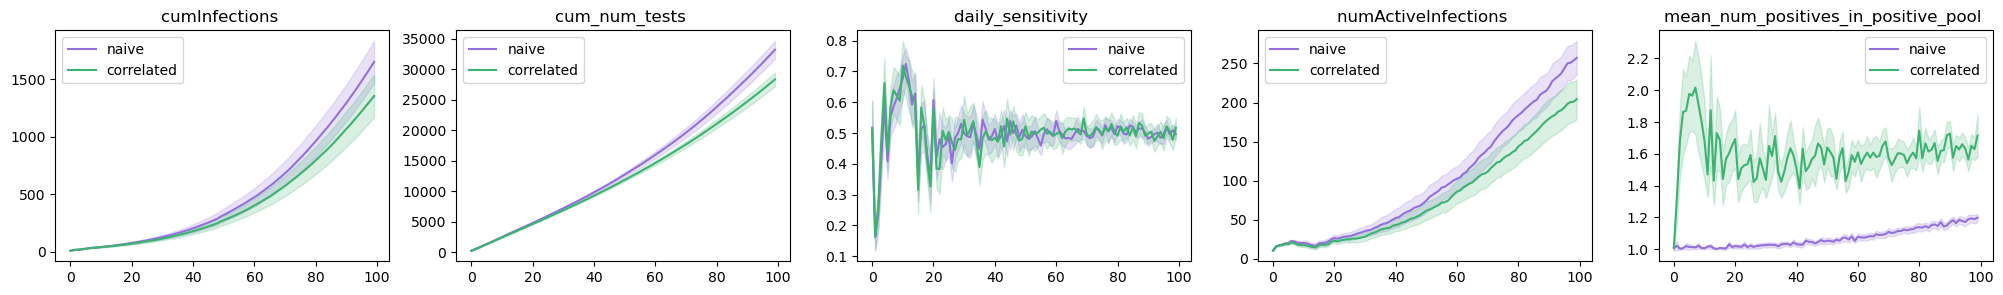

init_prev=0.01, peak_VL=6.0, num_groups=5, alpha=2.0, pool_size=10, LoD=1240, edge_weight=10


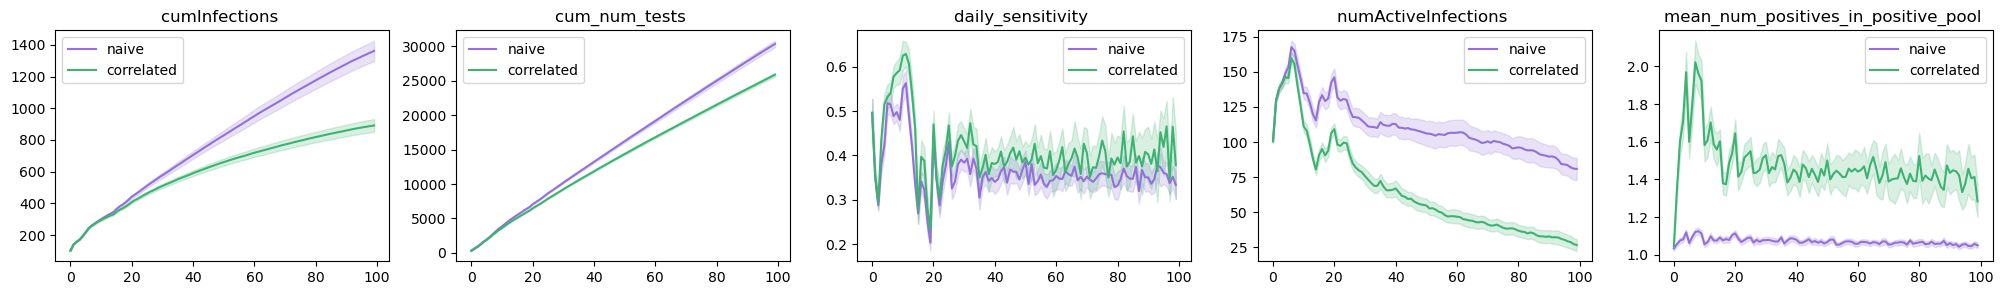

init_prev=0.01, peak_VL=6.5, num_groups=5, alpha=2.0, pool_size=10, LoD=1240, edge_weight=10


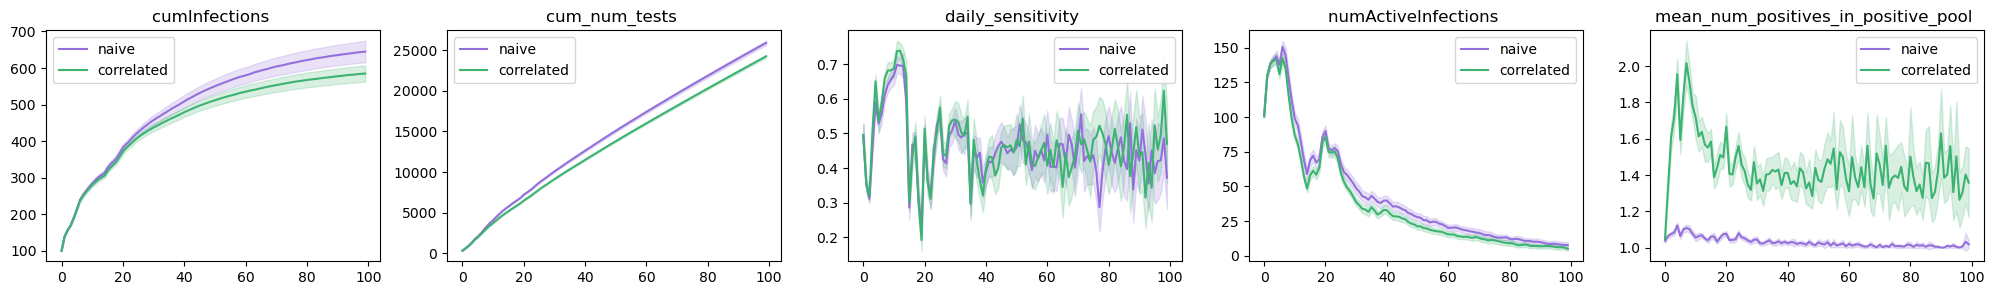

init_prev=0.01, peak_VL=7.0, num_groups=5, alpha=2.0, pool_size=10, LoD=1240, edge_weight=10


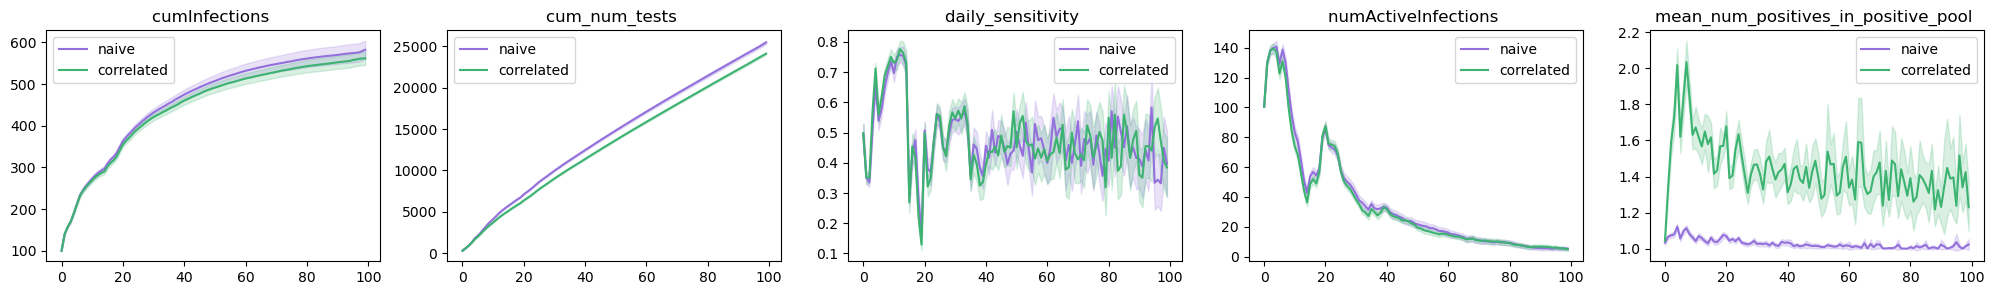

init_prev=0.01, peak_VL=6.0, num_groups=5, alpha=5.0, pool_size=10, LoD=1240, edge_weight=10


init_prev=0.01, peak_VL=6.5, num_groups=5, alpha=5.0, pool_size=10, LoD=1240, edge_weight=10


init_prev=0.01, peak_VL=7.0, num_groups=5, alpha=5.0, pool_size=10, LoD=1240, edge_weight=10


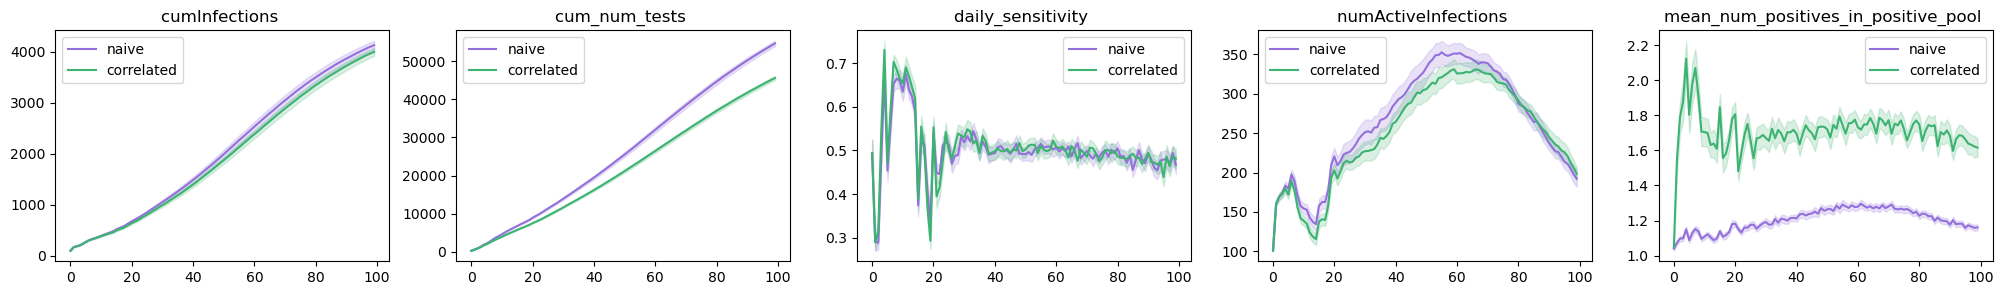

init_prev=0.1, peak_VL=6.0, num_groups=5, alpha=2.0, pool_size=10, LoD=1240, edge_weight=10


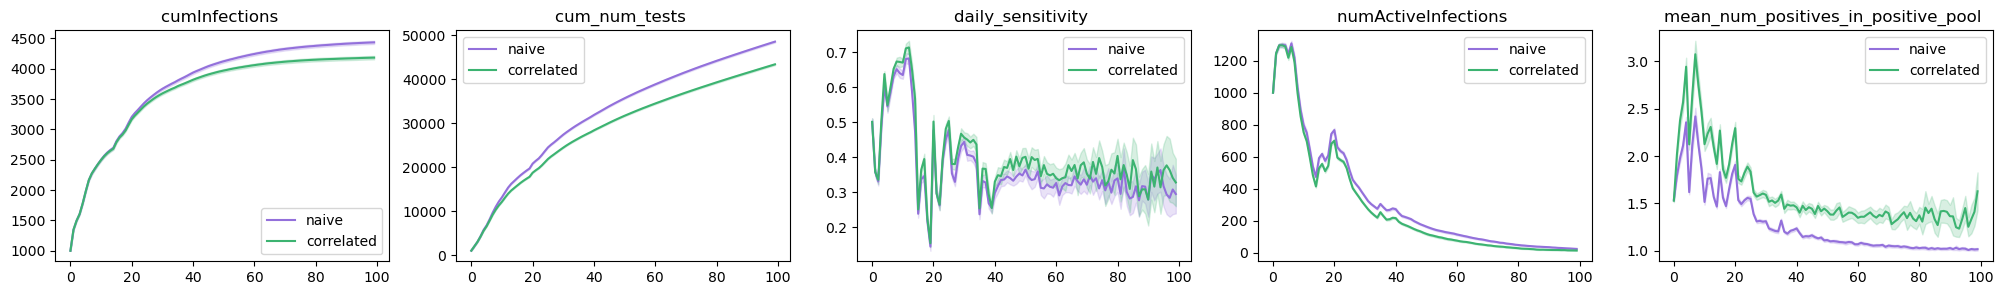

init_prev=0.1, peak_VL=6.5, num_groups=5, alpha=2.0, pool_size=10, LoD=1240, edge_weight=10


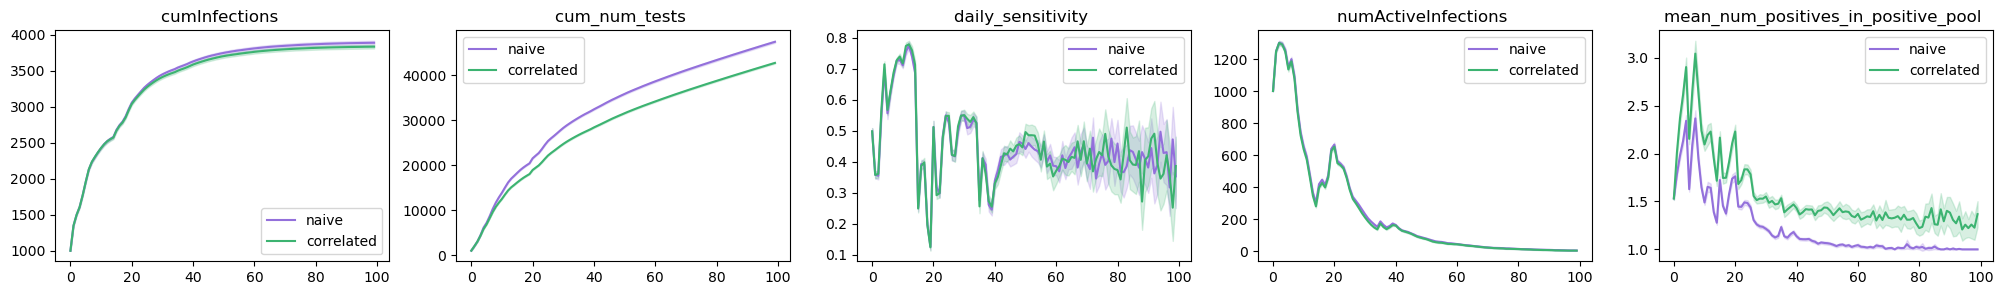

init_prev=0.1, peak_VL=7.0, num_groups=5, alpha=2.0, pool_size=10, LoD=1240, edge_weight=10


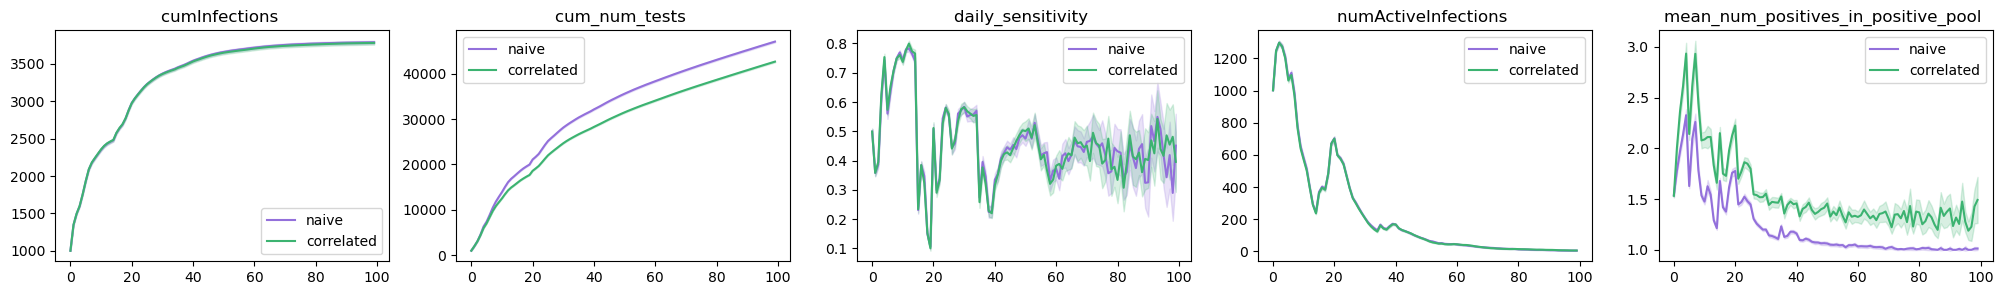

init_prev=0.1, peak_VL=6.0, num_groups=5, alpha=5.0, pool_size=10, LoD=1240, edge_weight=10


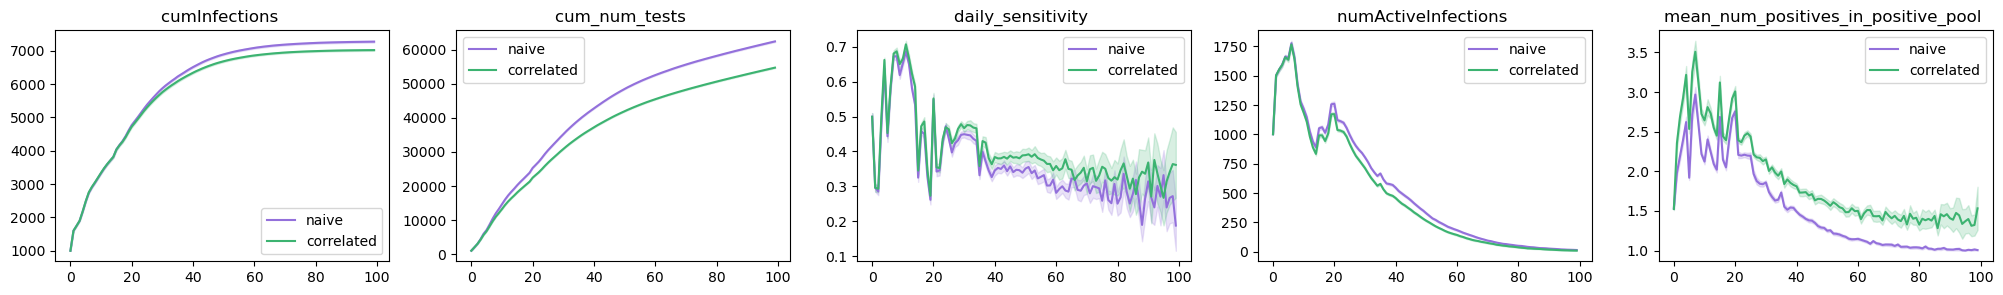

init_prev=0.1, peak_VL=6.5, num_groups=5, alpha=5.0, pool_size=10, LoD=1240, edge_weight=10


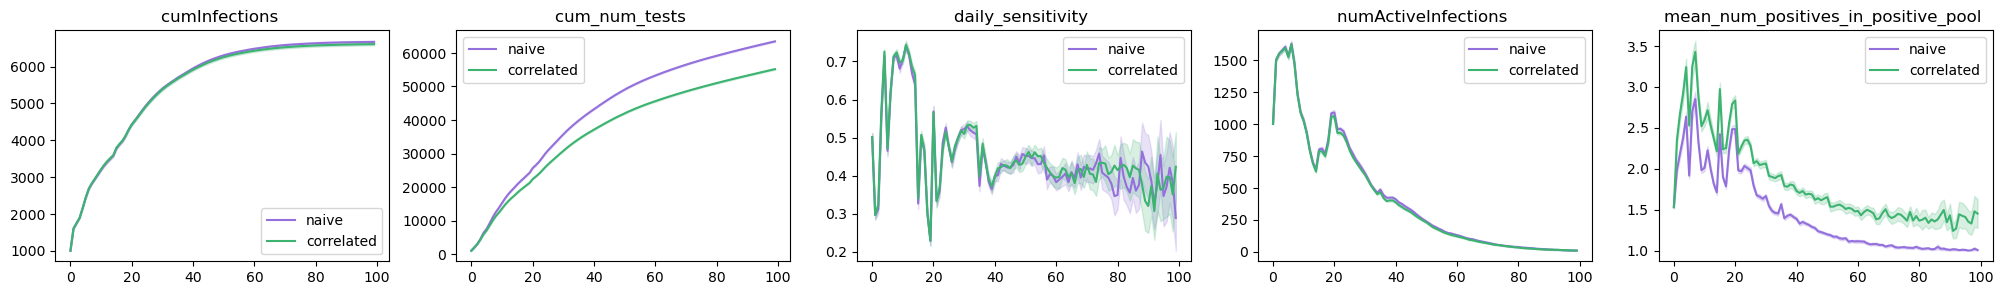

init_prev=0.1, peak_VL=7.0, num_groups=5, alpha=5.0, pool_size=10, LoD=1240, edge_weight=10


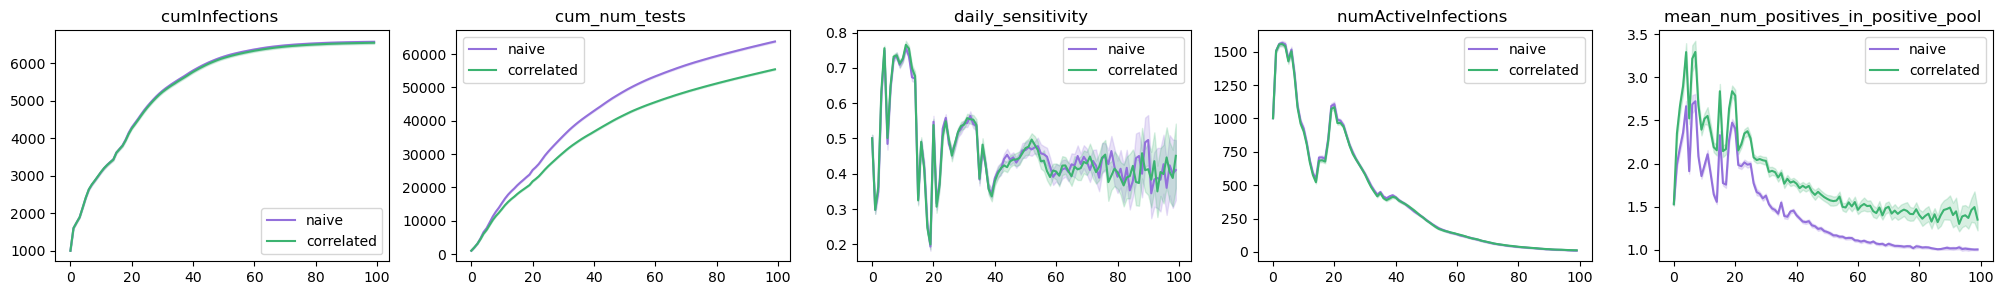

In [24]:
for j in range(len(trajectories)):
    plot_trajectory(trajectories[j])

In [25]:
import pandas as pd
df = pd.DataFrame(all_data)
df.dropna(inplace=True)


In [26]:
df

country  pop_size  init_prev  num_groups  pool_size  horizon  beta  sigma   
0       US     10000      0.001           5         10      100   0.1    0.2  \
1       US     10000      0.001           5         10      100   0.1    0.2   
2       US     10000      0.001           5         10      100   0.1    0.2   
3       US     10000      0.001           5         10      100   0.1    0.2   
4       US     10000      0.001           5         10      100   0.1    0.2   
5       US     10000      0.001           5         10      100   0.1    0.2   
6       US     10000      0.010           5         10      100   0.1    0.2   
7       US     10000      0.010           5         10      100   0.1    0.2   
8       US     10000      0.010           5         10      100   0.1    0.2   
9       US     10000      0.010           5         10      100   0.1    0.2   
10      US     10000      0.010           5         10      100   0.1    0.2   
11      US     10000      0.010           5         10      100   0.1    0.2   
12      US     10000      0.100           5         10      100   0.1    0.2   
13      US     10000      0.100           5         10      100   0.1    0.2   
14      US     10000      0.100           5         10      100   0.1    0.2   
15      US     10000      0.100           5         10      100   0.1    0.2   
16      US     10000      0.100           5         10      100   0.1    0.2   
17      US     10000      0.100           5         10      100   0.1    0.2   

    lamda  gamma  ...  cum_num_tests_NP_mean  cum_num_tests_CP_mean   
0     0.5   0.25  ...           22152.062500           20959.041667  \
1     0.5   0.25  ...           21153.166667           20825.153846   
2     0.5   0.25  ...           20695.375000           20708.235294   
3     0.5   0.25  ...           55092.220000           40402.200000   
4     0.5   0.25  ...           38843.660000           30897.333333   
5     0.5   0.25  ...           33218.204082           28332.693878   
6     0.5   0.25  ...           30361.620000           25888.000000   
7     0.5   0.25  ...           25914.100000           24255.740000   
8     0.5   0.25  ...           25480.510638           24122.708333   
9     0.5   0.25  ...           62596.440000           51748.480000   
10    0.5   0.25  ...           58590.120000           47441.140000   
11    0.5   0.25  ...           54628.020000           45563.240000   
12    0.5   0.25  ...           48545.540000           43386.040000   
13    0.5   0.25  ...           47397.760000           42710.660000   
14    0.5   0.25  ...           47074.820000           42663.380000   
15    0.5   0.25  ...           62452.100000           54750.700000   
16    0.5   0.25  ...           63461.480000           55183.640000   
17    0.5   0.25  ...           63771.520000           55430.220000   

    cum_num_tests_NP_sem  cum_num_tests_CP_sem  daily_sensitivity_NP_mean   
0             255.256471             72.003929                   0.353567  \
1              77.343861             62.058157                   0.461000   
2              19.000123             31.185235                   0.457073   
3             584.909658            687.271422                   0.393212   
4            1100.779931            764.994140                   0.475097   
5             734.543092            565.050281                   0.500480   
6             231.607003            126.776673                   0.366004   
7             128.182415             83.532316                   0.456785   
8             100.873537             61.377717                   0.474405   
9              86.171662            117.786513                   0.391216   
10            250.717255            227.324885                   0.480848   
11            344.634533            243.386618                   0.501330   
12             98.579333             90.547821                   0.363997   
13            111.671728             78.292480        

In [27]:
df["cumInfections_diff"] = df["cumInfections_NP_mean"] - df["cumInfections_CP_mean"]
df["cum_num_tests_diff"] = df["cum_num_tests_NP_mean"] - df["cum_num_tests_CP_mean"]

df["cumInfections_diff_rel"] = (df["cumInfections_NP_mean"] - df["cumInfections_CP_mean"])/df["cumInfections_NP_mean"]
df["cum_num_tests_diff_rel"] = (df["cum_num_tests_NP_mean"] - df["cum_num_tests_CP_mean"]) / df["cum_num_tests_NP_mean"]


In [28]:
# df.drop(columns=[
#     "country", "pop_size", "num_groups", "edge_weight", "alpha", "LoD", "pool_size", "horizon", "beta", "sigma", "lamda", "gamma",
#     "cumInfections_diff", "cum_num_tests_diff"
#     ])

df[
    [
        "init_prev", "peak_VL", "alpha", "pool_size", "num_groups",
        "cumInfections_diff_rel",
        "cum_num_tests_diff_rel",
        "daily_sensitivity_NP_mean", "daily_sensitivity_CP_mean"
    ]
]

# df[(df["init_prev"]>=0.05)].drop(columns=["pop_size", "horizon", "beta", "sigma", "lamda", "gamma"])

init_prev  peak_VL  alpha  pool_size  num_groups  cumInfections_diff_rel   
0       0.001      6.0    2.0         10           5                0.504112  \
1       0.001      6.5    2.0         10           5                0.104072   
2       0.001      7.0    2.0         10           5               -0.300505   
3       0.001      6.0    5.0         10           5                0.297510   
4       0.001      6.5    5.0         10           5                0.270304   
5       0.001      7.0    5.0         10           5                0.179668   
6       0.010      6.0    2.0         10           5                0.345627   
7       0.010      6.5    2.0         10           5                0.093471   
8       0.010      7.0    2.0         10           5                0.035007   
9       0.010      6.0    5.0         10           5                0.117127   
10      0.010      6.5    5.0         10           5                0.084950   
11      0.010      7.0    5.0         10           5                0.031756   
12      0.100      6.0    2.0         10           5                0.056767   
13      0.100      6.5    2.0         10           5                0.013951   
14      0.100      7.0    2.0         10           5                0.002323   
15      0.100      6.0    5.0         10           5                0.034752   
16      0.100      6.5    5.0         10           5                0.009031   
17      0.100      7.0    5.0         10           5                0.003698   

    cum_num_tests_diff_rel  daily_sensitivity_NP_mean   
0                 0.053856                   0.353567  \
1                 0.015507                   0.461000   
2                -0.000621                   0.457073   
3                 0.266644                   0.393212   
4                 0.204572                   0.475097   
5                 0.147073                   0.500480   
6                 0.147345                   0.366004   
7                 0.063995                   0.456785   
8                 0.053288                   0.474405   
9                 0.173300                   0.391216   
10                0.190288                   0.480848   
11                0.165936                   0.501330   
12                0.106282                   0.363997   
13                0.098889                   0.443723   
14                0.093711                   0.456910   
15                0.123317                   0.363680   
16                0.130439                   0.445242   
17                0.130800                   0.460438   

    daily_sensitivity_CP_mean  
0                    0.405117  
1                    0.450906  
2                    0.468143  
3                    0.447106  
4                    0.495484  
5                    0.501901  
6                    0.411223  
7                    0.468763  
8                    0.475439  
9                    0.446803  
10                   0.496371  
11                   0.505789  
12                   0.394446  
13                   0.444512  
14                   0.456690  
15                   0.401707  
16                   0.449505  
17                   0.457742

In [42]:
colordict

{0.001: 0.0, 0.01: 0.5, 0.1: 1.0}

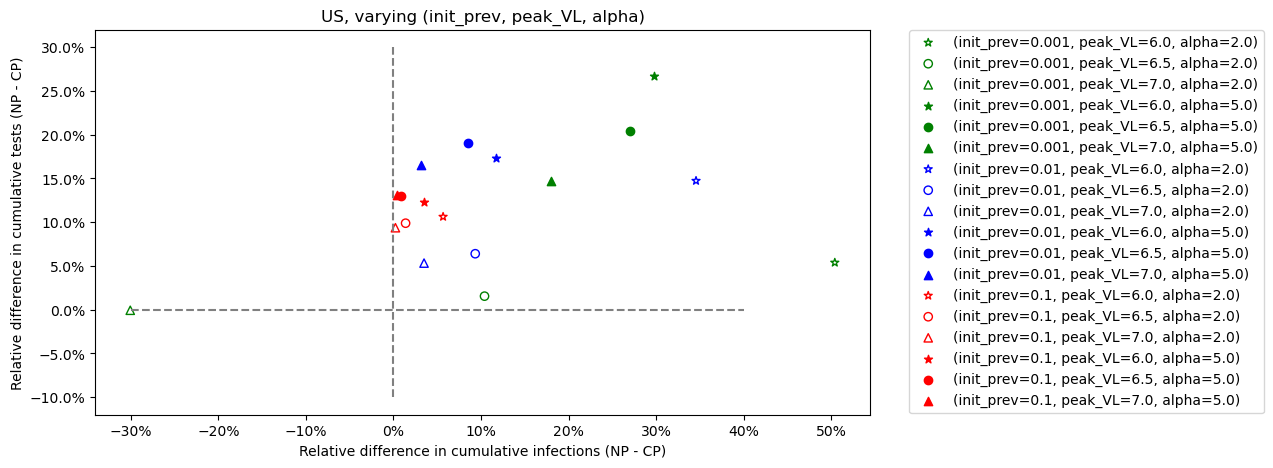

In [37]:
import matplotlib.ticker as mtick

df_country = df[df["country"] == "US"]

init_prev_values = np.unique(df["init_prev"])
colordict = {
    0.001: "green",
    0.01: "blue",
    0.1: "red"
}
markerdict = {
    6.0: "*",
    7.0: "^",
    6.5: "o"
}

fillstyledict = {
    2.0: "none",
    5.0: "full",
}

plt.figure(figsize=(10,5))
for _, row in df_country.iterrows():
    plt.scatter(
        row["cumInfections_diff_rel"], 
        row["cum_num_tests_diff_rel"], 
        # c = (np.log10(df["init_prev"])),
        # c=df_country["init_prev"].apply(lambda x: colordict[x])
        edgecolors=colordict[row["init_prev"]],
        marker=markerdict[row["peak_VL"]],
        facecolors="none" if row["alpha"] == 2.0 else colordict[row["init_prev"]],
        label=f"(init_prev={row['init_prev']}, peak_VL={row['peak_VL']}, alpha={row['alpha']})"
    )

plt.hlines(0,-0.3, 0.4, color="gray", linestyle="--")
plt.vlines(0,-0.1,0.3, color="gray", linestyle="--")
plt.xlabel("Relative difference in cumulative infections (NP - CP)")
plt.ylabel("Relative difference in cumulative tests (NP - CP)")

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))


plt.title("US, varying (init_prev, peak_VL, alpha)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [26]:

paths = {}

param_to_vary = "alpha"


for param_val in param_config[param_to_vary]:
    # path = "../results/US"
    path = "/home/yz685/corr_pooling_seirsplus/scripts/results/US"

    for param_name in [
        "pop_size", "init_prev", "num_groups", "pool_size", "horizon", 
        "beta", "sigma", "lamda", "gamma", "LoD", "edge_weight", "alpha"
    ]:
            
        if param_name == param_to_vary:
            path += f"_{param_name}={param_val}"
        else:
            path += f"_{param_name}={param_config[param_name+'_default']}"
        
    # paths[param_val] = path





In [27]:
from collections import defaultdict
def defaultdict_list():
    return defaultdict(list)

results = defaultdict(defaultdict_list) # dict of dict of list of individual results

for param_val, path in paths.items():
    for pooling_strategy in ["naive", "correlated"]:
        for i in range(1, NUM_TRIALS+1):
            filepath = path + f"/{pooling_strategy}/results_{i}.pickle"
            try:
                with open(filepath, "rb") as f:
                    results[pooling_strategy][param_val].append(pickle.load(f))
            except Exception as e:
                print("error: ", e)
                continue


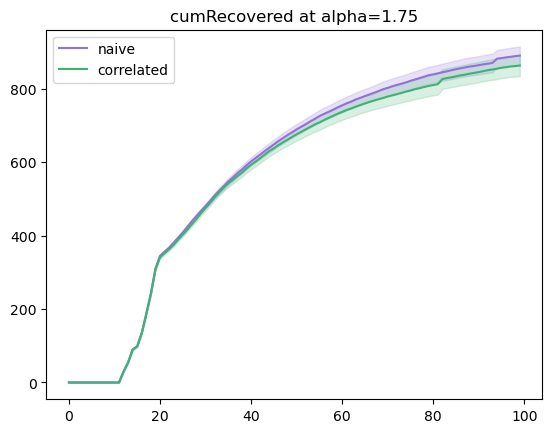

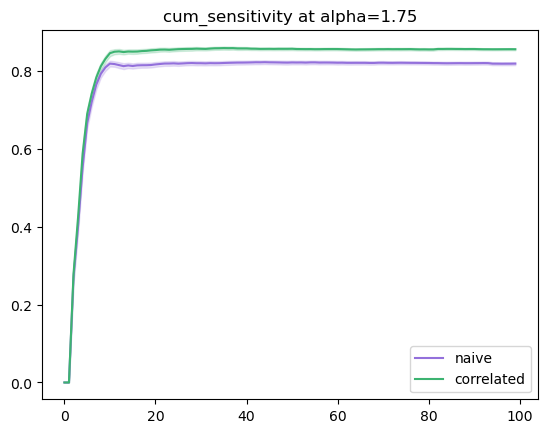

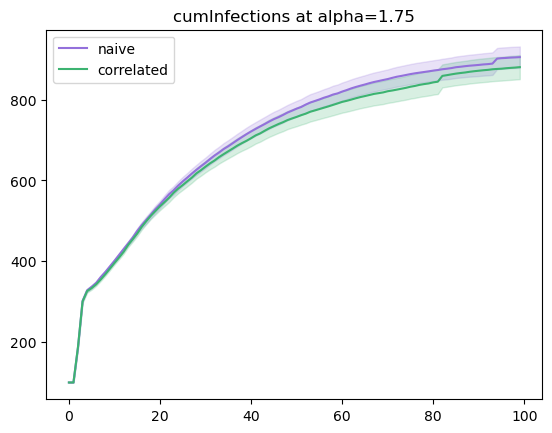

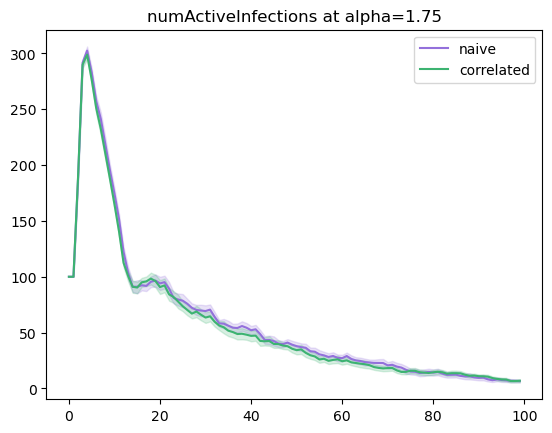

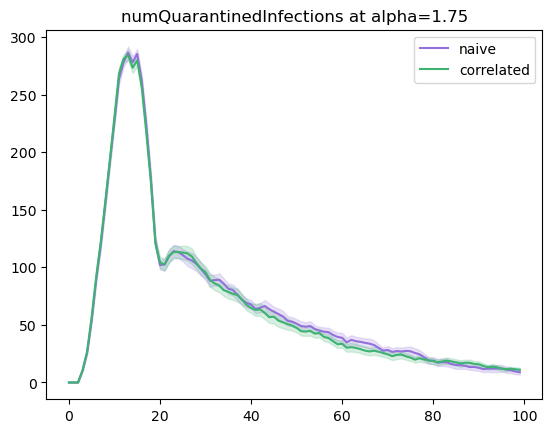

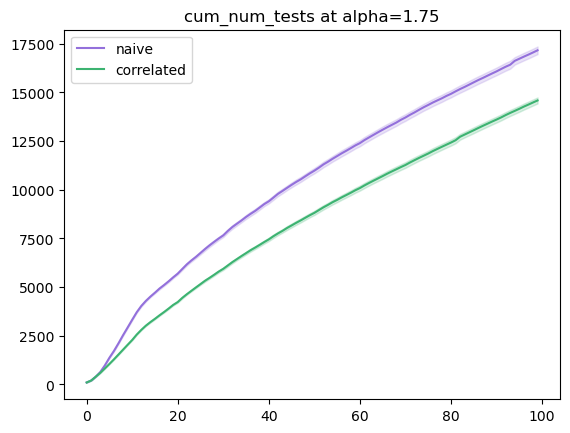

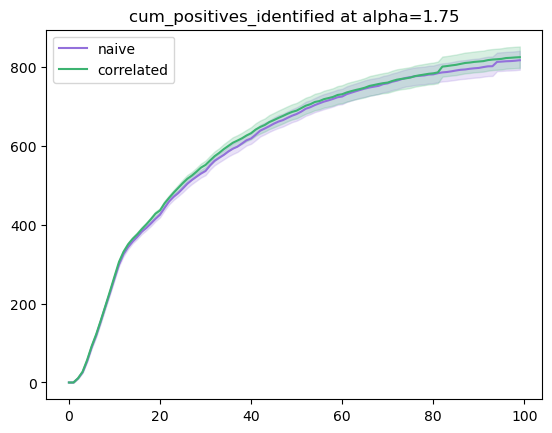

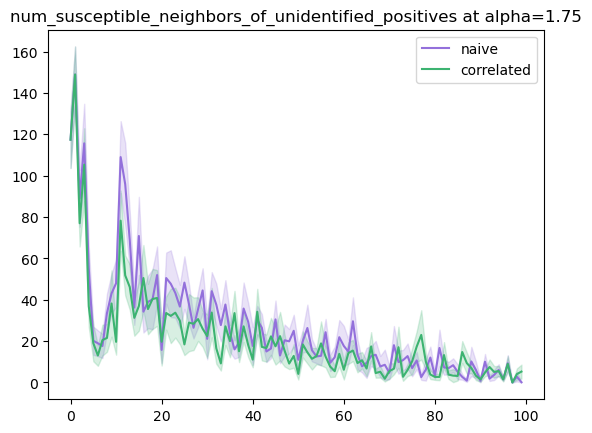

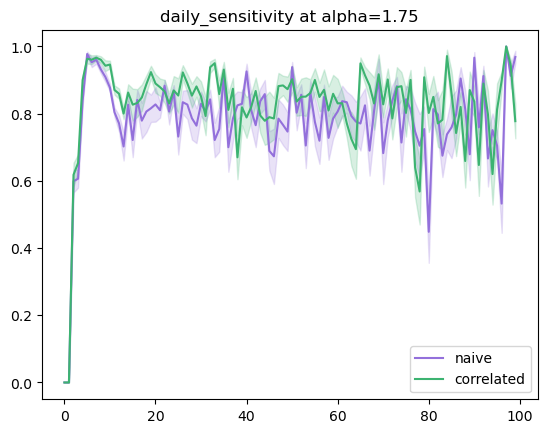

In [31]:
PARAM_VAL= 1.75
metrics = set(results["correlated"][PARAM_VAL][0][0].keys()) - set(["day"])

for metric in metrics:
# for metric in ["cumInfections", "cum_num_tests"]:
    naive_results = []
    correlated_results = []
    for SEED in range(20):
        try:
            naive_results.append(
                [x[metric]\
                for x in results["naive"][PARAM_VAL][SEED]]
            )
        except:
            pass
        try:
            correlated_results.append(
                [x[metric]\
                for x in results["correlated"][PARAM_VAL][SEED]]
            )
        except:
            pass

    naive_results_ = np.array([(xi+[None]*(100-len(xi)))[:100] for xi in naive_results], dtype=float)
    correlated_results_ = np.array([(xi+[None]*(100-len(xi)))[:100] for xi in correlated_results][:100], dtype=float)
    naive_mean = np.nanmean(naive_results_, axis=0)
    naive_std = np.nanstd(naive_results_, axis=0)/np.sqrt(NUM_TRIALS)
    correlated_mean = np.nanmean(correlated_results_, axis=0)
    correlated_std = np.nanstd(correlated_results_, axis=0)/np.sqrt(NUM_TRIALS)
    
    plt.plot(naive_mean, color="mediumpurple", label="naive")
    plt.fill_between(
        range(len(naive_mean)),
        naive_mean-naive_std,
        naive_mean+naive_std,
        alpha=0.2,
        color="mediumpurple"
    )
    plt.plot(correlated_mean, color="mediumseagreen", label="correlated")
    plt.fill_between(
        range(len(correlated_mean)),
        correlated_mean-correlated_std,
        correlated_mean+correlated_std,
        alpha=0.2,
        color="mediumseagreen"
    )
    plt.title(f"{metric} at {param_to_vary}={PARAM_VAL}")
    plt.legend()
    plt.show()